In [1]:
from comet import COMET
from models.encoder import FTClassifier
# import datautils
from tasks.fine_tuning import finetune_fit
from tasks.fine_tuning import finetune_predict
from tasks.linear_evaluation import eval_classification
from dataloading.ptb_preprocessing import load_ptb
from config_files.PTB_Configs import Config as Configs

import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
import sklearn
from tqdm import tqdm
from utils import plot_channels
from utils import process_batch_ts
from utils import split_data_label
from utils import start_logging
from utils import stop_logging
from utils import seed_everything

from datetime import datetime

In [2]:
configs = Configs()
RANDOM_SEED = configs.RANDOM_SEED

# Autoload the modified python file
%reload_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Specify saving and logging directory

In [3]:
working_directory = configs.working_directory
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

logging_directory = configs.logging_directory
if not os.path.exists(logging_directory):
    os.makedirs(logging_directory)

In [4]:
test = np.load("../MCP/chapman/label/label.npy")
test

array([[   1,    1],
       [   0,    2],
       [   3,    3],
       ...,
       [   2, 9711],
       [   2, 9712],
       [   2, 9713]])

In [5]:
def segment(X, y, sample):
    '''
    segment the trial to non-overlapping samples
    '''
    length = X.shape[1]
    assert length % sample == 0
    nsample = length / sample
    
    samples = X.reshape(-1, sample, X.shape[-1])
    tids = np.repeat(np.arange(y.shape[0])+1, nsample)
    labels = np.repeat(y, nsample, axis=0)
    labels = np.hstack([labels, tids.reshape(labels.shape[0], -1)])
    return samples, labels

In [6]:
def load_chapman(root='data/chapman', split=None):
    data_path = os.path.join(root, 'feature')
    label_path = os.path.join(root, 'label', 'label.npy')
    
    labels = np.load(label_path)
    
    pids_sb = list(labels[np.where(labels[:, 0]==0)][:, 1])
    pids_af = list(labels[np.where(labels[:, 0]==1)][:, 1])
    pids_gsvt = list(labels[np.where(labels[:, 0]==2)][:, 1])
    pids_sr = list(labels[np.where(labels[:, 0]==3)][:, 1])
    
    train_ids = pids_sb[:-500] + pids_af[:-500] + pids_gsvt[:-500] + pids_sr[:-500]
    valid_ids = pids_sb[-500:-250] + pids_af[-500:-250] + pids_gsvt[-500:-250] + pids_sr[-500:-250]
    test_ids = pids_sb[-250:] + pids_af[-250:] + pids_gsvt[-250:] + pids_sr[-250:]
    
    filenames = []
    for fn in os.listdir(data_path):
        filenames.append(fn)
    filenames.sort()
    
    train_trials = []
    train_labels = []
    valid_trials = []
    valid_labels = []
    test_trials = []
    test_labels = []
    
    for i, fn in enumerate(tqdm(filenames)):
        label = labels[i]
        feature = np.load(os.path.join(data_path, fn))
        for trial in feature:
            if i+1 in train_ids:
                train_trials.append(trial)
                train_labels.append(label)
            elif i+1 in valid_ids:
                valid_trials.append(trial)
                valid_labels.append(label)
            elif i+1 in test_ids:
                test_trials.append(trial)
                test_labels.append(label)
                
    X_train = np.array(train_trials)
    X_val = np.array(valid_trials)
    X_test = np.array(test_trials)
    y_train = np.array(train_labels)
    y_val = np.array(valid_labels)
    y_test = np.array(test_labels)
        
    if split:
        X_train, y_train = segment(X_train, y_train, split)
        X_val, y_val = segment(X_val, y_val, split)
        X_test, y_test = segment(X_test, y_test, split)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = load_chapman(root='../MCP/chapman', split=300)

100%|██████████| 9713/9713 [00:07<00:00, 1337.37it/s]


#### Load and preprocessing data

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(82434, 300, 12)
(12642, 300, 12)
(13290, 300, 12)
(82434, 3)
(12642, 3)
(13290, 3)


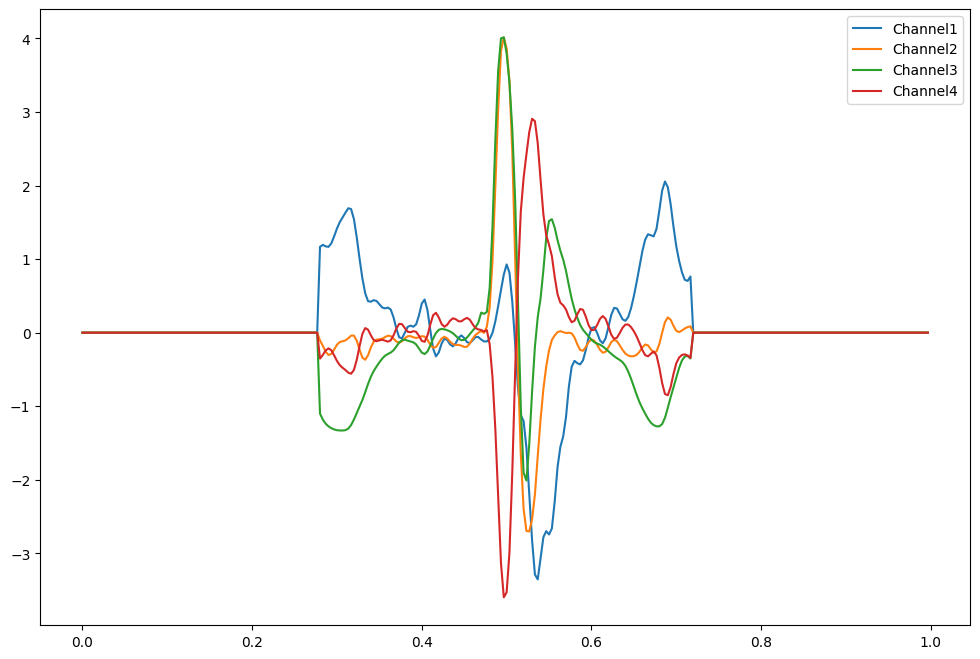

In [9]:
# plot first sample, first four channels
plot_channels(1, X_train[0][:,:4])

## Train model

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The program will run on {device}!")

The program will run on cuda!


### Callback functions

In [11]:
def pretrain_callback(model, loss):
    n = model.n_epochs
    metrics_dict = {}
    if n % 1 == 0:
        metrics_dict = eval_classification(model, X_train, y_train[:, 0], X_val, y_val[:, 0], fraction=1)
        print(metrics_dict)
        model.save(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")
    return metrics_dict['F1']

In [12]:
def finetune_callback(model, f1, fraction=1.0):
    n = model.n_epochs
    if model.n_epochs == 1:
        model.finetune_f1 = f1
        torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    # control the saving frequency
    if n % 1 == 0:
        if f1 > model.finetune_f1:
            model.finetune_f1 = f1
            torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    return finetune_callback

In [34]:
checkpoint = torch.load("../CLOCS/CMSC/chapman/leads_['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']/embedding_320/seed42/pretrained_weight.pt")

In [36]:
checkpoint

OrderedDict([('encoder.input_fc.weight',
              tensor([[nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
                      [nan],
  

## Linear evaluation

In [13]:
start_time = datetime.now()
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=12,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    flag_use_multi_gpu=configs.flag_use_multi_gpu,
    after_epoch_callback=pretrain_callback,
)

pretrain_model.load(f"pretrained_weight.pt")

start_logging(RANDOM_SEED, logging_directory)
val_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_val, y_val[:, 0])
print("Linear evaluation for validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_test, y_test[:, 0])
print("Linear evaluation for test set\n",test_metrics_dict)
print()
stop_logging()

FileNotFoundError: [Errno 2] No such file or directory: 'pretrained_weight'

## Full fine-tuning

In [16]:
checkpoint = torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")
for k in list(checkpoint.keys()):
    if k.startswith('module.module.'):
        checkpoint[k.replace('module.module.', 'module.')] = checkpoint[k]
        del checkpoint[k]

In [13]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=12, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=4, device=device, flag_use_multi_gpu=False)
# finetune_model.net.load_state_dict(checkpoint)

In [18]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_100, finetune_epochs=configs.finetune_epochs_100, num_classes=4, finetune_lr=configs.finetune_lr_100, fraction=configs.fraction_100, device=device, callback=finetune_callback)

100%|██████████| 645/645 [00:20<00:00, 31.27it/s]


Epoch number: 0
Loss: 0.41362937536350514
{'Accuracy': 0.6080525233349153, 'Precision': 0.7605107588084143, 'Recall': 0.7109319955967738, 'F1': 0.657994557699207, 'AUROC': np.float64(0.9126670681575341), 'AUPRC': np.float64(0.8124980056248529)}


100%|██████████| 645/645 [00:19<00:00, 32.51it/s]


Epoch number: 1
Loss: 0.3357982505950355
{'Accuracy': 0.5794178136370828, 'Precision': 0.7254237200079415, 'Recall': 0.6989897408998273, 'F1': 0.5963296903143912, 'AUROC': np.float64(0.8812210594864949), 'AUPRC': np.float64(0.7546505841847431)}


100%|██████████| 645/645 [00:19<00:00, 32.33it/s]


Epoch number: 2
Loss: 0.2958750110880041
{'Accuracy': 0.403812687865844, 'Precision': 0.42837753499000375, 'Recall': 0.5222418739087371, 'F1': 0.38951556359276107, 'AUROC': np.float64(0.8739252277251227), 'AUPRC': np.float64(0.7400489125054381)}


100%|██████████| 645/645 [00:19<00:00, 32.27it/s]


Epoch number: 3
Loss: 0.2720070326773002
{'Accuracy': 0.5832146812213257, 'Precision': 0.7074517272278521, 'Recall': 0.7117555223628033, 'F1': 0.5940335141158501, 'AUROC': np.float64(0.8590355090068402), 'AUPRC': np.float64(0.7294315508200546)}


100%|██████████| 645/645 [00:19<00:00, 32.94it/s]


Epoch number: 4
Loss: 0.25427917104127795
{'Accuracy': 0.5358329378262933, 'Precision': 0.6691675636750348, 'Recall': 0.6524562144996251, 'F1': 0.530903610569748, 'AUROC': np.float64(0.838842420260862), 'AUPRC': np.float64(0.7234483395199407)}


100%|██████████| 645/645 [00:19<00:00, 32.58it/s]


Epoch number: 5
Loss: 0.24086398434096065
{'Accuracy': 0.5665242841322575, 'Precision': 0.64972773933343, 'Recall': 0.6868246601334643, 'F1': 0.5825366575003923, 'AUROC': np.float64(0.8818844281358572), 'AUPRC': np.float64(0.7632601247223115)}


100%|██████████| 645/645 [00:19<00:00, 32.34it/s]


Epoch number: 6
Loss: 0.22793635641980672
{'Accuracy': 0.5229394083214681, 'Precision': 0.6196288973105581, 'Recall': 0.6423045166823074, 'F1': 0.5162438569832521, 'AUROC': np.float64(0.8550192715802614), 'AUPRC': np.float64(0.7317687006571802)}


100%|██████████| 645/645 [00:19<00:00, 32.29it/s]


Epoch number: 7
Loss: 0.21695058527655264
{'Accuracy': 0.6064704951748141, 'Precision': 0.7356610289093716, 'Recall': 0.7272353586539848, 'F1': 0.6429815769026819, 'AUROC': np.float64(0.8652394760287802), 'AUPRC': np.float64(0.7485038034837183)}


100%|██████████| 645/645 [00:20<00:00, 32.23it/s]


Epoch number: 8
Loss: 0.2077326365200278
{'Accuracy': 0.6254548330960291, 'Precision': 0.728984346288963, 'Recall': 0.737364242575601, 'F1': 0.6761287580491017, 'AUROC': np.float64(0.8737615398166368), 'AUPRC': np.float64(0.7599588144163648)}


100%|██████████| 645/645 [00:19<00:00, 32.62it/s]


Epoch number: 9
Loss: 0.1997302743093681
{'Accuracy': 0.6254548330960291, 'Precision': 0.730797173724788, 'Recall': 0.7407758813418933, 'F1': 0.6693331836336696, 'AUROC': np.float64(0.8725975961258288), 'AUPRC': np.float64(0.7625889566871166)}


100%|██████████| 645/645 [00:19<00:00, 32.64it/s]


Epoch number: 10
Loss: 0.1920189188828743
{'Accuracy': 0.606233190950799, 'Precision': 0.7168145343062631, 'Recall': 0.7287986853532107, 'F1': 0.6454012306436959, 'AUROC': np.float64(0.8615959602792087), 'AUPRC': np.float64(0.7373864701524222)}


100%|██████████| 645/645 [00:19<00:00, 33.02it/s]


Epoch number: 11
Loss: 0.1853281110556416
{'Accuracy': 0.6144597373833254, 'Precision': 0.7197957159619373, 'Recall': 0.7313350601594076, 'F1': 0.6582112143043954, 'AUROC': np.float64(0.8709497620214147), 'AUPRC': np.float64(0.7511652932410441)}


100%|██████████| 645/645 [00:19<00:00, 32.66it/s]


Epoch number: 12
Loss: 0.17970267765392806
{'Accuracy': 0.6272741654801456, 'Precision': 0.6644513896192634, 'Recall': 0.7133625023921053, 'F1': 0.672245842285802, 'AUROC': np.float64(0.8722246240850592), 'AUPRC': np.float64(0.7418886211266249)}


100%|██████████| 645/645 [00:19<00:00, 32.49it/s]


Epoch number: 13
Loss: 0.17405487452061272
{'Accuracy': 0.598718557190318, 'Precision': 0.6793230047679556, 'Recall': 0.7128340986249229, 'F1': 0.6372345834806167, 'AUROC': np.float64(0.8771184271801672), 'AUPRC': np.float64(0.7481135047390571)}


100%|██████████| 645/645 [00:19<00:00, 32.30it/s]


Epoch number: 14
Loss: 0.16965414590459768
{'Accuracy': 0.6017244106945103, 'Precision': 0.6613846973809563, 'Recall': 0.7041738392094475, 'F1': 0.6435145473393276, 'AUROC': np.float64(0.8791054649856682), 'AUPRC': np.float64(0.7444045492990938)}


100%|██████████| 645/645 [00:19<00:00, 32.47it/s]


Epoch number: 15
Loss: 0.16489646330759175
{'Accuracy': 0.5921531403258978, 'Precision': 0.671599164032656, 'Recall': 0.711691665050348, 'F1': 0.640337344774806, 'AUROC': np.float64(0.8578493528527249), 'AUPRC': np.float64(0.7229026055494745)}


100%|██████████| 645/645 [00:20<00:00, 32.22it/s]


Epoch number: 16
Loss: 0.16098589612340075
{'Accuracy': 0.6550387596899225, 'Precision': 0.7232628342673869, 'Recall': 0.7413566970853911, 'F1': 0.7131705077440981, 'AUROC': np.float64(0.8868652999228676), 'AUPRC': np.float64(0.7717114399201302)}


100%|██████████| 645/645 [00:19<00:00, 32.28it/s]


Epoch number: 17
Loss: 0.15716006579326786
{'Accuracy': 0.6268786584401203, 'Precision': 0.7064686740214146, 'Recall': 0.7229392480803087, 'F1': 0.688518995150908, 'AUROC': np.float64(0.8710298088060123), 'AUPRC': np.float64(0.7482880725969352)}


100%|██████████| 645/645 [00:19<00:00, 32.51it/s]


Epoch number: 18
Loss: 0.15338227460765014
{'Accuracy': 0.6040974529346622, 'Precision': 0.6957468841045475, 'Recall': 0.7170408491327319, 'F1': 0.6619608882402325, 'AUROC': np.float64(0.8702320908500041), 'AUPRC': np.float64(0.750643726187987)}


100%|██████████| 645/645 [00:19<00:00, 32.54it/s]


Epoch number: 19
Loss: 0.15013010859049047
{'Accuracy': 0.6144597373833254, 'Precision': 0.6864929213877091, 'Recall': 0.717498156472288, 'F1': 0.6733013262130775, 'AUROC': np.float64(0.865810243984605), 'AUPRC': np.float64(0.7401736477325068)}


100%|██████████| 645/645 [00:19<00:00, 32.45it/s]


Epoch number: 20
Loss: 0.14661194420739013
{'Accuracy': 0.6120866951431736, 'Precision': 0.6791838536443966, 'Recall': 0.7127535117089713, 'F1': 0.6696997981201194, 'AUROC': np.float64(0.8551212768837537), 'AUPRC': np.float64(0.7225037773499808)}


100%|██████████| 645/645 [00:19<00:00, 32.74it/s]


Epoch number: 21
Loss: 0.14321192630019938
{'Accuracy': 0.597452934662237, 'Precision': 0.6661264499456239, 'Recall': 0.7078493728820544, 'F1': 0.6535508418414704, 'AUROC': np.float64(0.852343632015758), 'AUPRC': np.float64(0.716720188105651)}


100%|██████████| 645/645 [00:19<00:00, 32.65it/s]


Epoch number: 22
Loss: 0.1400911657443508
{'Accuracy': 0.6210251542477456, 'Precision': 0.7096840085978089, 'Recall': 0.7277619718623263, 'F1': 0.6745492384244811, 'AUROC': np.float64(0.8777578737512388), 'AUPRC': np.float64(0.7589289483910664)}


100%|██████████| 645/645 [00:19<00:00, 32.34it/s]


Epoch number: 23
Loss: 0.1371166807808432
{'Accuracy': 0.6120866951431736, 'Precision': 0.6900190196823952, 'Recall': 0.7205585133083273, 'F1': 0.663551728742053, 'AUROC': np.float64(0.862456697643423), 'AUPRC': np.float64(0.7339948703637207)}


100%|██████████| 645/645 [00:19<00:00, 32.77it/s]


Epoch number: 24
Loss: 0.13426236692452154
{'Accuracy': 0.6067077993988294, 'Precision': 0.6883442707736188, 'Recall': 0.7207121842491243, 'F1': 0.6495397722436107, 'AUROC': np.float64(0.8776837294274422), 'AUPRC': np.float64(0.7580664496152065)}


100%|██████████| 645/645 [00:19<00:00, 32.80it/s]


Epoch number: 25
Loss: 0.1315498571504423
{'Accuracy': 0.6241892105679481, 'Precision': 0.7045594723076221, 'Recall': 0.7278988837277438, 'F1': 0.6825517597906586, 'AUROC': np.float64(0.8697280091382904), 'AUPRC': np.float64(0.7581609115010737)}


100%|██████████| 645/645 [00:19<00:00, 32.81it/s]


Epoch number: 26
Loss: 0.1290360931400397
{'Accuracy': 0.6196013289036545, 'Precision': 0.7188071161869252, 'Recall': 0.7318144224807708, 'F1': 0.6708250608370575, 'AUROC': np.float64(0.8899932032131646), 'AUPRC': np.float64(0.7788382764044597)}


100%|██████████| 645/645 [00:19<00:00, 32.72it/s]


Epoch number: 27
Loss: 0.12664081442522057
{'Accuracy': 0.6107419712070875, 'Precision': 0.7251929947505275, 'Recall': 0.7297682883467242, 'F1': 0.6515670271491696, 'AUROC': np.float64(0.8593057397188432), 'AUPRC': np.float64(0.7424418101840976)}


100%|██████████| 645/645 [00:20<00:00, 32.15it/s]


Epoch number: 28
Loss: 0.12475475992495082
{'Accuracy': 0.6121657965511786, 'Precision': 0.7107941185750228, 'Recall': 0.7235273507856249, 'F1': 0.6616339477249586, 'AUROC': np.float64(0.8659228229857343), 'AUPRC': np.float64(0.7601995803568644)}


100%|██████████| 645/645 [00:19<00:00, 32.56it/s]


Epoch number: 29
Loss: 0.12248530782552229
{'Accuracy': 0.6158835627274165, 'Precision': 0.7210791641892881, 'Recall': 0.73049936638321, 'F1': 0.6609136056473223, 'AUROC': np.float64(0.8714276187895608), 'AUPRC': np.float64(0.7702350945797456)}


100%|██████████| 645/645 [00:19<00:00, 32.53it/s]


Epoch number: 30
Loss: 0.12025015680261457
{'Accuracy': 0.5977693402942572, 'Precision': 0.6922302714178903, 'Recall': 0.7141310556570966, 'F1': 0.6398453632729202, 'AUROC': np.float64(0.8662219572333454), 'AUPRC': np.float64(0.7592431295153778)}


100%|██████████| 645/645 [00:19<00:00, 32.34it/s]


Epoch number: 31
Loss: 0.1181250278682984
{'Accuracy': 0.6021199177345357, 'Precision': 0.7074909696345423, 'Recall': 0.7215243630755873, 'F1': 0.6437589696370195, 'AUROC': np.float64(0.8412443865210344), 'AUPRC': np.float64(0.7257237045929208)}


100%|██████████| 645/645 [00:19<00:00, 32.59it/s]


Epoch number: 32
Loss: 0.11606718934632686
{'Accuracy': 0.6038601487106471, 'Precision': 0.7179705392655072, 'Recall': 0.7251129710805209, 'F1': 0.6416140985489652, 'AUROC': np.float64(0.8558405207309107), 'AUPRC': np.float64(0.7454416298262613)}


100%|██████████| 645/645 [00:19<00:00, 32.39it/s]


Epoch number: 33
Loss: 0.11414821039672093
{'Accuracy': 0.6072615092548648, 'Precision': 0.7119138336944612, 'Recall': 0.7235087026193119, 'F1': 0.6492434317147815, 'AUROC': np.float64(0.8495644214170244), 'AUPRC': np.float64(0.7370652303363874)}


100%|██████████| 645/645 [00:19<00:00, 32.60it/s]


Epoch number: 34
Loss: 0.11230876979971942
{'Accuracy': 0.6194431260876444, 'Precision': 0.7208786180986082, 'Recall': 0.7311035542849105, 'F1': 0.6680863606383083, 'AUROC': np.float64(0.8735663642776219), 'AUPRC': np.float64(0.7622558256617795)}


100%|██████████| 645/645 [00:19<00:00, 32.32it/s]


Epoch number: 35
Loss: 0.11097666509176743
{'Accuracy': 0.6036228444866318, 'Precision': 0.679783951057322, 'Recall': 0.7159948465533263, 'F1': 0.6452610611755456, 'AUROC': np.float64(0.8722091891661293), 'AUPRC': np.float64(0.7491277484091997)}


100%|██████████| 645/645 [00:19<00:00, 32.57it/s]


Epoch number: 36
Loss: 0.10949884590460816
{'Accuracy': 0.6045720613826926, 'Precision': 0.7304315747328853, 'Recall': 0.7197760125649628, 'F1': 0.6397786478324923, 'AUROC': np.float64(0.871947858650559), 'AUPRC': np.float64(0.7612938914075762)}


100%|██████████| 645/645 [00:20<00:00, 32.15it/s]


Epoch number: 37
Loss: 0.10841598881964098
{'Accuracy': 0.6072615092548648, 'Precision': 0.7038276999631665, 'Recall': 0.7234625994583047, 'F1': 0.6532043711073346, 'AUROC': np.float64(0.8799361156108134), 'AUPRC': np.float64(0.7570872674706537)}


100%|██████████| 645/645 [00:19<00:00, 32.53it/s]


Epoch number: 38
Loss: 0.10689143601315708
{'Accuracy': 0.6119284923271634, 'Precision': 0.7110642001374933, 'Recall': 0.7259531309567269, 'F1': 0.6605199442499743, 'AUROC': np.float64(0.8729286200706562), 'AUPRC': np.float64(0.7604637071099235)}


100%|██████████| 645/645 [00:19<00:00, 32.47it/s]


Epoch number: 39
Loss: 0.10538255116175824
{'Accuracy': 0.5920740389178928, 'Precision': 0.6903818027696714, 'Recall': 0.7155481280329841, 'F1': 0.6260471616901389, 'AUROC': np.float64(0.863600454714448), 'AUPRC': np.float64(0.7504391048076022)}


100%|██████████| 645/645 [00:19<00:00, 32.47it/s]


Epoch number: 40
Loss: 0.10403743441120504
{'Accuracy': 0.6006169909824395, 'Precision': 0.7013067948431065, 'Recall': 0.7184449120722851, 'F1': 0.6378931584806233, 'AUROC': np.float64(0.8746073030836394), 'AUPRC': np.float64(0.7592711858152001)}


100%|██████████| 645/645 [00:19<00:00, 32.60it/s]


Epoch number: 41
Loss: 0.10260941324500802
{'Accuracy': 0.5929441544059484, 'Precision': 0.7156790643481075, 'Recall': 0.7166915395734185, 'F1': 0.6181667450378621, 'AUROC': np.float64(0.8592077011423619), 'AUPRC': np.float64(0.7477164053360623)}


100%|██████████| 645/645 [00:19<00:00, 32.60it/s]


Epoch number: 42
Loss: 0.10120647882405358
{'Accuracy': 0.5953171966461003, 'Precision': 0.6980856335890586, 'Recall': 0.7152116386138025, 'F1': 0.6278564896208219, 'AUROC': np.float64(0.8553210315714999), 'AUPRC': np.float64(0.7321419309774138)}


100%|██████████| 645/645 [00:19<00:00, 32.54it/s]


Epoch number: 43
Loss: 0.09980526735158746
{'Accuracy': 0.5868533459895586, 'Precision': 0.6927533571284411, 'Recall': 0.7084183741424626, 'F1': 0.6157268534653543, 'AUROC': np.float64(0.8465805064166594), 'AUPRC': np.float64(0.7267403940134631)}


100%|██████████| 645/645 [00:19<00:00, 32.31it/s]


Epoch number: 44
Loss: 0.098622130544565
{'Accuracy': 0.5862996361335232, 'Precision': 0.6848489783050437, 'Recall': 0.7082625999621449, 'F1': 0.6150064090966914, 'AUROC': np.float64(0.8061816173318204), 'AUPRC': np.float64(0.6920818341892927)}


100%|██████████| 645/645 [00:19<00:00, 32.58it/s]


Epoch number: 45
Loss: 0.09764389836476654
{'Accuracy': 0.587327954437589, 'Precision': 0.7192227236912183, 'Recall': 0.7101737947049427, 'F1': 0.60608728887086, 'AUROC': np.float64(0.8627373997731652), 'AUPRC': np.float64(0.7612788697421686)}


100%|██████████| 645/645 [00:19<00:00, 32.36it/s]


Epoch number: 46
Loss: 0.09672939706527009
{'Accuracy': 0.5946052839740548, 'Precision': 0.7037028913214443, 'Recall': 0.7177689692192787, 'F1': 0.6237220837814688, 'AUROC': np.float64(0.8741874432542609), 'AUPRC': np.float64(0.7506058484593257)}


100%|██████████| 645/645 [00:19<00:00, 32.29it/s]


Epoch number: 47
Loss: 0.09589914343813094
{'Accuracy': 0.5980857459262775, 'Precision': 0.7095664348064595, 'Recall': 0.7197317031887032, 'F1': 0.6314127041409814, 'AUROC': np.float64(0.8365588999030723), 'AUPRC': np.float64(0.7198909669501693)}


100%|██████████| 645/645 [00:19<00:00, 32.26it/s]


Epoch number: 48
Loss: 0.09531633512673095
{'Accuracy': 0.6245847176079734, 'Precision': 0.7477269740086138, 'Recall': 0.7393840699570698, 'F1': 0.6676973054944448, 'AUROC': np.float64(0.8734432041013931), 'AUPRC': np.float64(0.7675936852266203)}


100%|██████████| 645/645 [00:20<00:00, 32.11it/s]


Epoch number: 49
Loss: 0.09429283601125385
{'Accuracy': 0.6056794810947634, 'Precision': 0.7247835009315156, 'Recall': 0.7280791168613107, 'F1': 0.6427441987093392, 'AUROC': np.float64(0.8408049936779363), 'AUPRC': np.float64(0.7360196167840732)}


In [14]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_100}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_100} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_100} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

Finetune for 1.0 fraction of validation set
{'Accuracy': 0.6550387596899225, 'Precision': 0.7232628342673869, 'Recall': 0.7413566970853911, 'F1': 0.7131705077440981, 'AUROC': np.float64(0.8868654486162434), 'AUPRC': np.float64(0.7717115866289654)}
Finetune for 1.0 fraction of test set
{'Accuracy': 0.6786305492851769, 'Precision': 0.767482487372711, 'Recall': 0.7684018238373735, 'F1': 0.7418143136632527, 'AUROC': np.float64(0.8984601510034262), 'AUPRC': np.float64(0.7952860070604557)}



NameError: name 'epoch_loss_list' is not defined

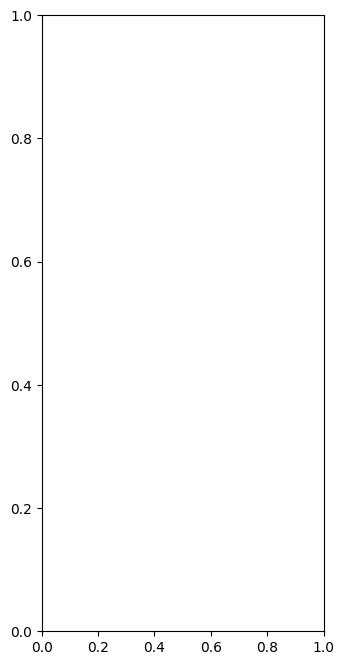

In [15]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Semi-supervised

### 10% label

In [ ]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

In [ ]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_10,finetune_epochs=configs.finetune_epochs_10, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_10, fraction=configs.fraction_10, device=device, callback=finetune_callback)

In [ ]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_10}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_10} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_10} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 1% label

In [ ]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

In [ ]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_1,finetune_epochs=configs.finetune_epochs_1, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_1, fraction=configs.fraction_1, device=device, callback=finetune_callback)

In [ ]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_1}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_1} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_1} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

In [ ]:
end_time = datetime.now()
print(f'Duration: {end_time - start_time}')